### GPU verification

In [1]:
# Test GPU on machine
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

/home/chanjunshern/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[22. 28.]
 [49. 64.]]


### Investigating recorded input/output from live demo

In [1]:
import numpy as np
import pianoroll_utils
from matplotlib import pyplot as plt
import pypianoroll

In [87]:
input_pianoroll = np.load('recorded_pianoroll.npy').swapaxes(0,1).reshape(96, 128)
comp_pianoroll = np.load('generated_pianoroll.npy').swapaxes(0,1).reshape(96, 128)
test = generated_pianoroll
# Plot comparison
fig, ax = plt.subplots()
fig.set_size_inches(10, 6, forward=True)
ax.set_title('Input')
pypianoroll.plot_pianoroll(ax, test, beat_resolution=24)
fig.tight_layout()

# Play comparison
# pianoroll_utils.playPianoroll(test)

NameError: name 'generated_pianoroll' is not defined

### Investigating playpianoroll_events

In [3]:
from keras.models import load_model
MODEL_AUTOENCODER_FILE = './models/autoencoder_v4.h5'
autoencoder = load_model(MODEL_AUTOENCODER_FILE)

Using TensorFlow backend.


In [4]:
from keras.models import Model
# Normalize input_pianoroll
input_pianoroll = np.load('recorded_pianoroll.npy')
input_pianoroll = input_pianoroll / 127.
# Get encoding of the input
input_pianoroll = input_pianoroll.reshape(1, 128, 96, 1)
autoencoder_output = autoencoder.predict(input_pianoroll) # (1, 128, 96, 1)
assert autoencoder_output.shape == (1, 128, 96, 1)
print "Getting autoencoder stuff", autoencoder_output.shape
# print np.sum(input_pianoroll - autoencoder_output)
print np.sum(input_pianoroll)
print np.amin(autoencoder_output)
# output_pianoroll = autoencoder_output[0].reshape(128, 96)

Getting autoencoder stuff (1, 128, 96, 1)
55.90551181102363
0.0


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  3.4705973  20.77994    24.45203     0.877367    0.          3.9844081
  6.5914383   5.171249    1.4545087   2.5562441   3.8582234   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.03607762  9.261589   13.108125   16.930813   20.213509   17.428322
 17.123474    3.6582694   3.8401468   0.          0.          0.90885544
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.

0

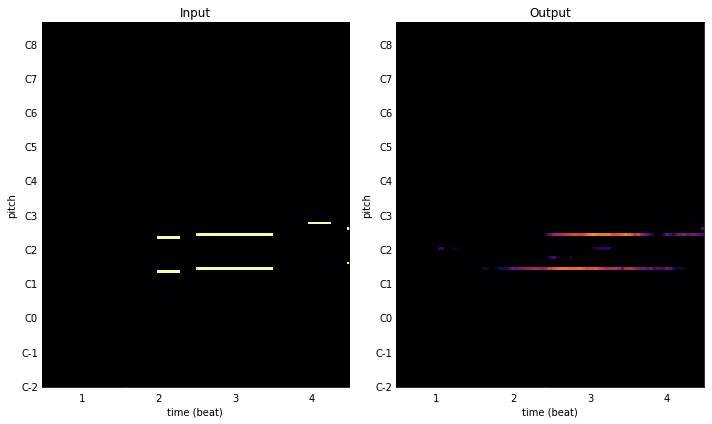

In [46]:
import pianoroll_utils

sample_input = input_pianoroll.reshape(128,96).swapaxes(0,1).reshape(96, 128) * 127
sample_output = autoencoder_output[0].swapaxes(0,1).reshape(96, 128) * 127
print sample_output[:,48]
# Plot comparison
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(sample_output)

In [49]:
input_pianoroll = np.load('recorded_pianoroll.npy')
print input_pianoroll.shape

print("")
print("Input")
play_midi_events(pianoroll_2_events(input_pianoroll))

print("")
print("Output")
play_midi_events(pianoroll_2_events(autoencoder_output.reshape(128,96) * 127))

(128, 96)

Input

Output


In [48]:
# print np.amax(autoencoder_output)
output = autoencoder_output.reshape(128,96) / np.amax(autoencoder_output) * 127
print output[48,:]

0.76522815
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  4.5353756  27.15522    31.953907    1.146543    0.          5.206824
  8.61369     6.757787    1.9007516   3.3404996   5.041926    0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.04714623 12.103043   17.129694   22.125185   26.415009   22.775328
 22.376951    4.7806253   5.0183034   0.          0.          1.1876922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        

note_on channel=0 note=48 velocity=117 time=0.25
note_on channel=0 note=48 velocity=0 time=0.0840909090909
note_on channel=0 note=48 velocity=127 time=0.0204545454545
note_on channel=0 note=48 velocity=0 time=0.125
note_on channel=0 note=41 velocity=126 time=0.0613636363636
note_on channel=0 note=40 velocity=127 time=0.188636363636
note_on channel=0 note=40 velocity=0 time=0.0409090909091
note_on channel=0 note=53 velocity=127 time=0.188636363636
note_on channel=0 note=45 velocity=127 time=0.0204545454545
note_on channel=0 note=45 velocity=0 time=0.104545454545
note_on channel=0 note=45 velocity=127 time=0.0204545454545
note_on channel=0 note=45 velocity=0 time=0.0613636363636
note_on channel=0 note=45 velocity=80 time=0.0431818181818
note_on channel=0 note=45 velocity=0 time=0.0409090909091
note_on channel=0 note=48 velocity=113 time=0
note_on channel=0 note=48 velocity=0 time=0.188636363636
note_on channel=0 note=48 velocity=90 time=0.0409090909091
note_on channel=0 note=48 velocity=0 time=0.0204545454545
note_on channel=0 note=53 velocity=0 time=0.188636363636
note_on channel=0 note=53 velocity=127 time=0.0409090909091
note_on channel=0 note=41 velocity=0 time=0.145454545455
note_on channel=0 note=55 velocity=127 time=0.104545454545
note_on channel=0 note=53 velocity=0 time=0.0204545454545
note_on channel=0 note=55 velocity=0 time=0

note_on channel=5 note=48 velocity=15 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=48 velocity=3 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=41 velocity=8 time=0
note_on channel=5 note=41 velocity=0 time=0
note_on channel=5 note=41 velocity=50 time=0
note_on channel=5 note=40 velocity=3 time=0
note_on channel=5 note=40 velocity=0 time=0
note_on channel=5 note=53 velocity=66 time=0
note_on channel=5 note=45 velocity=14 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=45 velocity=4 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=45 velocity=2 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=48 velocity=12 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=53 velocity=0 time=0
note_on channel=5 note=53 velocity=32 time=0
note_on channel=5 note=41 velocity=0 time=0
note_on channel=5 note=55 velocity=29 time=0

### LSTM sequence learning

Sources:
- Keras [docs](https://keras.io/preprocessing/sequence/#timeseriesgenerator) for TimeSeriesGenerator
- [StackOverflow](https://stackoverflow.com/questions/49555701/timeseriesgenerator-for-two-or-more-inputs) question on multiple input timeseriesgenerator

In [1]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Model, Sequential  
from keras.layers import Input, Activation, Dense, LSTM, Concatenate
# from keras.layers.core import Dense, Activation
# from keras.layers.recurrent import LSTM

import pandas as pd
import numpy as np

/home/human/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Sequence predictor

In [8]:
from keras.utils import Sequence

class TimeseriesGeneratorCustom(Sequence):
    """Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    # Arguments
    """

    def __init__(self, data, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data = data
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples[j] = self.data[indices]
            targets[j] = self.targets[rows[j]]
        if self.reverse:
            return samples[:, ::-1, ...], targets
        return samples, targets

    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        pass

    def __iter__(self):
        """Create an infinite generator that iterate over the Sequence."""
        while True:
            for item in (self[i] for i in range(len(self))):
                yield item

In [9]:
# Use keras TimeseriesGenerator to turn a sequence
# into multiple windows of sequences
WINDOW_LENGTH = 4

# def get_generator(data, targets, window_length = 5, batch_size = 32):
#     while True:
#         data_gen = TimeseriesGenerator(data, targets, length=window_length, 
#                                        sampling_rate=1, batch_size=batch_size)
#         for i in range(len(data_gen)):
#             x, y = data_gen[i]
#             yield x, y

class CustomGen(TimeseriesGenerator):
    def __getitem__(self, idx):
        x, y = TimeseriesGenerator.__getitem__(self, idx)
        # do processing here
        return x, y

data = np.arange(0,100).reshape(-1,1)
data_gen_custom = TimeseriesGeneratorCustom(data, data, length=WINDOW_LENGTH, sampling_rate=1, batch_size=1)
data_gen = TimeseriesGenerator(data, data, length=WINDOW_LENGTH, sampling_rate=1, batch_size=1)

In [10]:
data_dim = 1
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(100)(input1)

hidden = Dense(20, activation='relu')(lstm1)
output = Dense(data_dim, activation='linear')(hidden)

model = Model(inputs=input1, outputs=output)
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________


In [11]:
# and now train the model
# batch_size should be appropriate to your memory size
model.fit_generator(generator=data_gen_custom,
                    steps_per_epoch=32,
                    epochs=50)

Epoch 1/50
32/32 [==============================] - 1s 31ms/step - loss: 2470.8388 - acc: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 2437.9167 - acc: 0.0312
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 1884.0048 - acc: 0.0625
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 861.9349 - acc: 0.0312
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 885.3431 - acc: 0.0312
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 548.7989 - acc: 0.0625
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 324.5852 - acc: 0.0938
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 129.7269 - acc: 0.1250
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 88.3675 - acc: 0.1250
Epoch 10/50
32/32 [==============================] - 0s 7ms/step - loss: 38.0719 - acc: 0.2188
Epoch 11/50
32/32 [========================

In [163]:
input1 = np.arange(80,84).reshape(1,WINDOW_LENGTH,1)

predicted = model.predict(input1)
print(predicted)

[[88.76638]]


#### Multi-sequence predictor

In [17]:
from keras.utils import Sequence

class TimeseriesGeneratorTwoInputs(Sequence):
    """Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    
    Adapted from the TimeseriesGenerator class:
    https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
    """

    def __init__(self, data1, data2, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data1 = data1
        self.data2 = data2
        assert len(data1) == len(data2)
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data1) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data1.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(samples_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples1, samples2, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples1[j] = self.data1[indices]
            samples2[j] = self.data2[indices]
            targets[j] = self.targets[rows[j]]
        if self.reverse:
            return [samples1[:, ::-1, ...], samples2[:, ::-1, ...]], targets
        return [samples1, samples2], targets


In [18]:
data1 = np.arange(0,100).reshape(-1,1)
data2 = np.arange(0,100).reshape(-1,1)
data_gen = TimeseriesGeneratorTwoInputs(data1, data2, data2, length=WINDOW_LENGTH, sampling_rate=1, batch_size=1)

In [25]:
data_dim = 1

# First layer
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
input2 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(100)(input1)
lstm2 = LSTM(100)(input2)

# Second layer
merged = keras.layers.concatenate([lstm1, lstm2])

# Third layer
hidden = Dense(20, activation='relu')(merged)
output = Dense(data_dim, activation='linear')(hidden)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 4, 1)         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 4, 1)         0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 100)          40800       input_9[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 100)          40800       input_10[0][0]                   
__________________________________________________________________________________________________
concatenat

In [26]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
# model.fit(X_train, y_train, batch_size=450, epochs=10, validation_split=0.05)
model.fit_generator(generator=data_gen,
                    steps_per_epoch=32,
                    epochs=50)

Epoch 1/50
32/32 [==============================] - 2s 63ms/step - loss: 2304.6477 - acc: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 1496.8769 - acc: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 773.9431 - acc: 0.0312
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 312.1340 - acc: 0.0938
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 136.2790 - acc: 0.0625
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 55.5633 - acc: 0.2188
Epoch 7/50
32/32 [==============================] - 0s 9ms/step - loss: 25.0596 - acc: 0.0938
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 11.9308 - acc: 0.0938
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 9.8678 - acc: 0.1562  ETA: 0s - loss: 10.1129 - acc: 0.000
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 4.8735 - acc: 0.1875
Epoch 1

In [29]:
input1 = np.arange(80,84).reshape(1,4,1)
input2 = np.arange(80,84).reshape(1,4,1) #np.arange(80,85).reshape(1,5,1)

predicted = model.predict([input1,input2])
print(predicted)

[[83.56241]]


#### Stateful predictor

Inspired by this [question](https://stackoverflow.com/questions/38081263/stream-output-of-predictions-in-keras).

In [153]:
# Use keras TimeseriesGenerator to turn a sequence
# into multiple windows of sequences
WINDOW_LENGTH = 4

def get_generator(data, targets, window_length = 5, batch_size = 32):
    while True:
        data_gen = TimeseriesGenerator(data, targets, length=window_length, 
                                       sampling_rate=1, batch_size=batch_size)
        for i in range(len(data_gen)):
            x, y = data_gen[i]
            yield x, y

data = np.arange(0,100).reshape(-1,1)
data_gen_custom = get_generator(data, data, window_length=WINDOW_LENGTH, batch_size=1)
data_gen = TimeseriesGenerator(data, data, length=WINDOW_LENGTH, sampling_rate=1, batch_size=1)

In [158]:
data_dim = 1
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(100)(input1)

hidden = Dense(20, activation='relu')(lstm1)
output = Dense(data_dim, activation='linear')(hidden)

model = Model(inputs=input1, outputs=output)
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 4, 1)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_23 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________


In [159]:
# and now train the model
# batch_size should be appropriate to your memory size
model.fit_generator(generator=data_gen_custom,
                    steps_per_epoch=32,
                    epochs=50)

Epoch 1/50
32/32 [==============================] - 2s 56ms/step - loss: 1207.1231 - acc: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 3078.6028 - acc: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 1717.6385 - acc: 0.4375
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 232.1851 - acc: 0.0000e+00
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 1245.5542 - acc: 0.0000e+00
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 721.2272 - acc: 0.2812
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 5.9430 - acc: 0.3125
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 230.0934 - acc: 0.0000e+00
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 174.0416 - acc: 0.0312
Epoch 10/50
32/32 [==============================] - 0s 9ms/step - loss: 1.5908 - acc: 0.0000e+00
Epoch 11/50
32/32 [=====

In [163]:
input1 = np.arange(80,84).reshape(1,WINDOW_LENGTH,1)

predicted = model.predict(input1)
print(predicted)

[[88.76638]]


### Handling large datasets

#### README

Required datasets and expected size:

#### 1. Units
- **Num units**: ~2,000,000 (approx 100 units per song)
- **Size per unit**: 36864 bytes (`unit.nbytes` = 8448 elements * float16)
- **Total size**: ~74GB (2,000,000 * 37kB) 

Expect less because many songs don't have pianorolls, and many pianorolls have empty units.

~~_Consider changing to float16?_~~ Done.

#### 2. Sequence
- **Window size**: 4
- **Input-Comp-y**: 9 units (4 + 4 + 1)
- **Num datapoints**: ~2,000,000
- **Total size**: ~700GB = 9 x 2,000,000 x 37kB

Let's not do it like this. :(

#### Using numpy memory maps

In [15]:
import numpy as np
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'newfile.dat') # create temp file for memmap
filename

'/tmp/tmpIRs4Qf/newfile.dat'

In [13]:
a = np.memmap(filename, dtype='float32', mode='w+', shape=(200000,1000))

In [16]:
a

memmap([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Using hdf5

##### Basics
From the [docs](http://docs.h5py.org/en/latest/quick.html#quick).

In [26]:
import h5py
import numpy as np
filename = "mytestfile.hdf5"
with h5py.File(filename, "w") as f:
    dset = f.create_dataset("mydataset", (100,), dtype='float32')
    print(dset.shape)
    dset = np.arange(100)

(100,)


In [28]:
with h5py.File('mytestfile.hdf5', 'r') as f:
    print(f.keys())
    print(f['mydataset'][...])

[u'mydataset']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


##### Resizable datasets
From [this StackOverflow question](https://stackoverflow.com/questions/25655588/incremental-writes-to-hdf5-with-h5py?rq=1).

In [16]:
NUM_PITCHES = 2
NUM_TICKS = 2

In [18]:
import os
import h5py
import numpy as np
path = '/tmp/out.h5'
os.remove(path)
with h5py.File(path, "a") as f:
    dset = f.create_dataset('units', (0, NUM_PITCHES, NUM_TICKS), maxshape=(None, NUM_PITCHES, NUM_TICKS),
                            dtype='float32', chunks=True)
    print(dset.shape)

    for i in range(3):
        # Load pianoroll
        # Extract units
        M = np.random.randint(5,10)
        units = np.random.rand(M, NUM_PITCHES, NUM_TICKS)
        
        # Append to dataset
        dset.resize(dset.shape[0]+M, axis=0)
        dset[-M:] = units
        
        print(dset.shape)

    print(dset[:])

(0, 2, 2)
(6, 2, 2)
(14, 2, 2)
(20, 2, 2)
[[[0.8500343  0.38689092]
  [0.77727604 0.81265455]]

 [[0.02969339 0.9345693 ]
  [0.7920879  0.6325009 ]]

 [[0.469871   0.9079007 ]
  [0.5759628  0.30690378]]

 [[0.8580788  0.4767191 ]
  [0.5276081  0.67525065]]

 [[0.5185089  0.28715146]
  [0.693969   0.04807708]]

 [[0.92874354 0.58465916]
  [0.55231214 0.9883768 ]]

 [[0.558073   0.5707375 ]
  [0.35652852 0.9255937 ]]

 [[0.15850353 0.6380559 ]
  [0.03733948 0.8015228 ]]

 [[0.4627496  0.29987308]
  [0.58572066 0.4374565 ]]

 [[0.2547735  0.0240215 ]
  [0.32339704 0.9560488 ]]

 [[0.5013472  0.15711232]
  [0.19503206 0.35899225]]

 [[0.20521723 0.16368036]
  [0.39066824 0.33925653]]

 [[0.00412564 0.1533687 ]
  [0.40302402 0.13068216]]

 [[0.1632349  0.3924986 ]
  [0.28279847 0.44609523]]

 [[0.07656287 0.96613854]
  [0.48486853 0.5650878 ]]

 [[0.6720959  0.5388782 ]
  [0.01575743 0.23220679]]

 [[0.28818586 0.02435029]
  [0.15015216 0.9223505 ]]

 [[0.27819735 0.8705458 ]
  [0.01930406 

### Sampling from convolutional output

In [1]:
import numpy as np
import pianoroll_utils
from matplotlib import pyplot as plt
import IPython

# Music shape
MIN_PITCH = 13 # 21 # A-1 (MIDI 21)
MAX_PITCH = 108 # C7 (MIDI 108)
BEATS_PER_UNIT = 4
NUM_TRANSPOSITIONS = 3 # Number of transpositions to perform (maximum 12)

# Don't change unless you know what you're doing
BEAT_RESOLUTION = 24 # This is set by the encoding of the lpd-5 dataset, corresponds to number of ticks per beat
PARTITION_NOTE = 60 # Break into left- and right-accompaniments at middle C
NUM_PITCHES = MAX_PITCH - MIN_PITCH + 1
NUM_TICKS = BEATS_PER_UNIT * BEAT_RESOLUTION
MEAN_THRESHOLD = 0.5/127. # Filter out units with mean values less than 0.5
NOTE_DROP_NOISE = 0.3 # Randomly drop 30% of notes when creating input_noisy dataset

In [2]:
samples = np.load('./pickle_jar/samples.npy')
samples_decoded = np.load('./pickle_jar/samples_decoded.npy')

print(samples.shape)
print(samples_decoded.shape)

(252, 96, 96, 1)
(252, 96, 96, 1)


In [191]:
reload(pianoroll_utils)

<module 'pianoroll_utils' from 'pianoroll_utils.py'>

In [194]:
x = np.array([[60, 62, 50, 65, 70, 70], 
              [30, 0, 30, 0, 0, 0]]) / 127.
pianoroll_utils.pianoroll_preprocess(x, 60, 61)

array([[0.48818898, 0.48818898, 0.48818898, 0.48818898, 0.48818898,
        0.48818898],
       [0.23622047, 0.        , 0.23622047, 0.        , 0.        ,
        0.        ]])

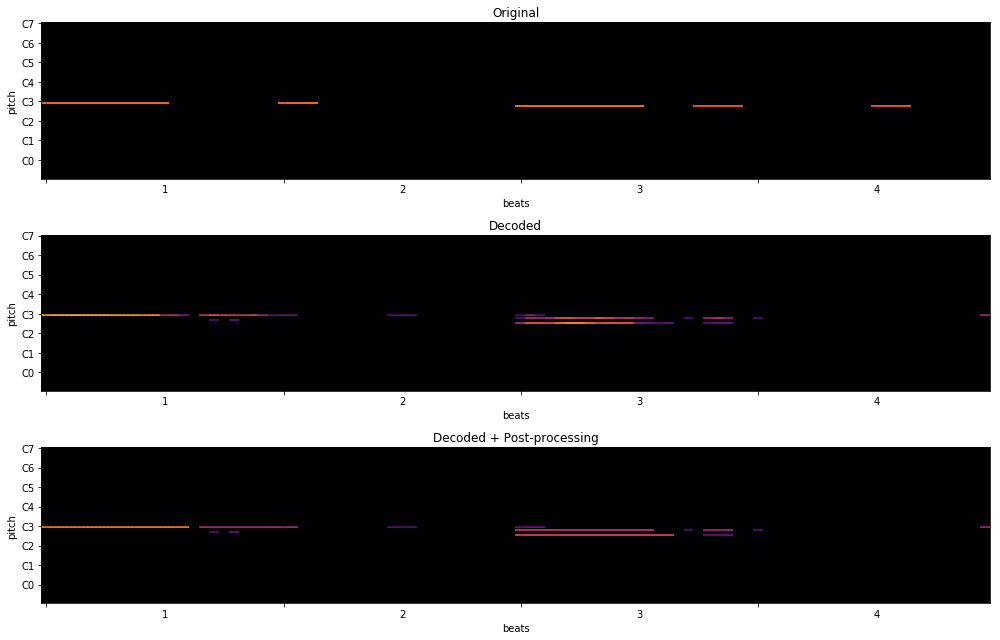

In [192]:
# Plot random input unit along with corresponding next and comp units
unit_index = np.random.randint(len(samples))
sample_unit = samples[unit_index].squeeze()
sample_unit_decoded = samples_decoded[unit_index].squeeze()
sample_unit_decoded_processed = pianoroll_utils.pianoroll_preprocess(sample_unit_decoded, MIN_PITCH, MAX_PITCH)

# Plot comparison
fig, ax = plt.subplots(3,1)
fig.set_size_inches(14, 9, forward=True)
ax[0].set_title('Original')
ax[1].set_title('Decoded')
ax[2].set_title('Decoded + Post-processing')
pianoroll_utils.plot_pianoroll(ax[0], sample_unit, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[1], sample_unit_decoded, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[2], sample_unit_decoded_processed, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Listen to the MIDI files
pianoroll_utils.play_pianoroll(sample_unit, MIN_PITCH, MAX_PITCH, '0')
pianoroll_utils.play_pianoroll(sample_unit_decoded, MIN_PITCH, MAX_PITCH, '1', process=False)
pianoroll_utils.play_pianoroll(sample_unit_decoded_processed, MIN_PITCH, MAX_PITCH, '1')